# DeepONet求解扩散反应方程 - PyTorch实现

本notebook实现了基于PyTorch的DeepONet算子网络，用于求解一维扩散反应方程。

**方程形式**: $u_t = (k(x) u_x)_x - v(x) u_x + g(u) + f(x)$

**主要组件**:
- Branch Network: 编码输入函数信息
- Trunk Network: 编码查询点坐标信息
- 通过内积运算得到最终输出

## 1. 导入必要的库

导入PyTorch、NumPy等必要的库，用于神经网络构建、数据处理和可视化。

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 检查GPU可用性
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'使用设备: {device}')

使用设备: cuda:1


## 2. 数据生成器类

自定义Dataset类，用于管理训练数据的批次生成。包含输入函数u、查询点y和对应的解s。

In [2]:
class DeepONetDataset(Dataset):
    def __init__(self, u, y, s):
        """
        u: 输入函数样本 (N*P, m)
        y: 查询点坐标 (N*P, 2) - (x, t)
        s: 对应的解值 (N*P, 1)
        """
        self.u = torch.FloatTensor(u)
        self.y = torch.FloatTensor(y) 
        self.s = torch.FloatTensor(s)
        
    def __len__(self):
        return len(self.u)
    
    def __getitem__(self, idx):
        return self.u[idx], self.y[idx], self.s[idx]

## 3. 多层感知器(MLP)定义

构建基础的全连接神经网络，使用tanh激活函数。这将作为Branch和Trunk网络的基础架构。

In [3]:
class MLP(nn.Module):
    def __init__(self, layers, activation=nn.Tanh()):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = activation
        
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            
        # Xavier初始化
        for layer in self.layers:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = self.activation(layer(x))
        x = self.layers[-1](x)  # 最后一层不加激活函数
        return x

## 4. DeepONet模型定义

实现完整的DeepONet架构，包含Branch网络、Trunk网络和最终的内积运算。

In [4]:
class DeepONet(nn.Module):
    def __init__(self, branch_layers, trunk_layers):
        super(DeepONet, self).__init__()
        
        self.branch_net = MLP(branch_layers)
        self.trunk_net = MLP(trunk_layers)
        
        # 确保branch和trunk输出维度相同
        assert branch_layers[-1] == trunk_layers[-1], "Branch和Trunk网络输出维度必须相同"
        
    def forward(self, u, y):
        """
        u: 输入函数 (batch_size, m)
        y: 查询点 (batch_size, 2)
        """
        # Branch网络编码输入函数
        branch_out = self.branch_net(u)  # (batch_size, p)
        
        # Trunk网络编码查询点
        trunk_out = self.trunk_net(y)    # (batch_size, p)
        
        # 内积运算
        output = torch.sum(branch_out * trunk_out, dim=1, keepdim=True)
        
        return output

## 5. 高斯随机场(GRF)生成函数

实现径向基函数(RBF)核，用于生成高斯随机场作为PDE的强迫项f(x)。

In [5]:
def rbf_kernel(x1, x2, output_scale=1.0, length_scale=0.2):
    """
    径向基函数核
    """
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(1, -1)
    
    r2 = ((x1 - x2) / length_scale) ** 2
    return output_scale * np.exp(-0.5 * r2)

def generate_grf_sample(x_grid, length_scale=0.2, output_scale=1.0):
    """
    生成高斯随机场样本
    """
    n = len(x_grid)
    K = rbf_kernel(x_grid, x_grid, output_scale, length_scale)
    
    # 添加数值稳定性的抖动
    jitter = 1e-10
    K += jitter * np.eye(n)
    
    # Cholesky分解采样
    L = np.linalg.cholesky(K)
    z = np.random.normal(0, 1, n)
    sample = L @ z
    
    return sample

## 6. 扩散反应方程数值求解器

使用有限差分方法求解一维扩散反应方程，生成训练数据。

In [6]:
def solve_diffusion_reaction(Nx, Nt, length_scale=0.2):
    """
    求解扩散反应方程: u_t = (k(x) u_x)_x - v(x) u_x + g(u) + f(x)
    """
    # 空间和时间域
    xmin, xmax = 0, 1
    tmin, tmax = 0, 1
    
    # 方程参数
    k = lambda x: 0.01 * np.ones_like(x)  # 扩散系数
    v = lambda x: np.zeros_like(x)        # 对流系数
    g = lambda u: 0.01 * u ** 2           # 反应项
    dg = lambda u: 0.02 * u               # 反应项导数
    u0 = lambda x: np.zeros_like(x)       # 初始条件
    
    # 生成网格
    x = np.linspace(xmin, xmax, Nx)
    t = np.linspace(tmin, tmax, Nt)
    h = x[1] - x[0]
    dt = t[1] - t[0]
    h2 = h ** 2
    
    # 生成强迫项(GRF样本)
    N_grf = 512
    x_grf = np.linspace(xmin, xmax, N_grf)
    grf_sample = generate_grf_sample(x_grf, length_scale)
    
    # 插值强迫项到计算网格
    f = np.interp(x, x_grf, grf_sample)
    
    # 计算系数
    k_vals = k(x)
    v_vals = v(x)
    
    # 有限差分算子
    D1 = np.eye(Nx, k=1) - np.eye(Nx, k=-1)
    D2 = -2 * np.eye(Nx) + np.eye(Nx, k=-1) + np.eye(Nx, k=1)
    D3 = np.eye(Nx - 2)
    
    M = -np.diag(D1 @ k_vals) @ D1 - 4 * np.diag(k_vals) @ D2
    m_bond = 8 * h2 / dt * D3 + M[1:-1, 1:-1]
    v_bond = 2 * h * np.diag(v_vals[1:-1]) @ D1[1:-1, 1:-1] + \
             2 * h * np.diag(v_vals[2:] - v_vals[:Nx-2])
    mv_bond = m_bond + v_bond
    c = 8 * h2 / dt * D3 - M[1:-1, 1:-1] - v_bond
    
    # 初始化解
    u = np.zeros((Nx, Nt))
    u[:, 0] = u0(x)
    
    # 时间步进
    for i in range(Nt - 1):
        gi = g(u[1:-1, i])
        dgi = dg(u[1:-1, i])
        h2dgi = np.diag(4 * h2 * dgi)
        A = mv_bond - h2dgi
        b1 = 8 * h2 * (0.5 * f[1:-1] + 0.5 * f[1:-1] + gi)
        b2 = (c - h2dgi) @ u[1:-1, i]
        u[1:-1, i + 1] = np.linalg.solve(A, b1 + b2)
    
    return x, t, u, f

## 7. 训练数据生成函数

生成DeepONet训练所需的数据集，包括输入函数、查询点和对应的解值。

In [7]:
def generate_training_data(N_samples, P_sensors, Nx=100, Nt=100, length_scale=0.2):
    """
    生成训练数据
    N_samples: 输入样本数量
    P_sensors: 每个样本的传感器数量
    """
    u_data = []
    y_data = []
    s_data = []
    
    m = Nx  # 输入传感器数量
    
    for _ in tqdm(range(N_samples), desc="生成训练数据"):
        # 求解PDE
        x, t, u_solution, f_input = solve_diffusion_reaction(Nx, Nt, length_scale)
        
        # 输入函数采样点(均匀分布在x方向)
        xx = np.linspace(0, 1, m)
        u_input = np.interp(xx, x, f_input)
        
        # 随机选择输出传感器位置
        idx_x = np.random.randint(0, Nx, P_sensors)
        idx_t = np.random.randint(0, Nt, P_sensors)
        
        y_sensors = np.column_stack([x[idx_x], t[idx_t]])
        s_sensors = u_solution[idx_x, idx_t]
        
        # 每个传感器点都对应同一个输入函数
        for i in range(P_sensors):
            u_data.append(u_input)
            y_data.append(y_sensors[i])
            s_data.append([s_sensors[i]])
    
    return np.array(u_data), np.array(y_data), np.array(s_data)

def generate_test_data(N_test, P_test, Nx=100, Nt=100, length_scale=0.2):
    """
    生成测试数据(全网格点)
    """
    u_test = []
    y_test = []
    s_test = []
    
    m = Nx
    
    for _ in range(N_test):
        # 求解PDE
        x, t, u_solution, f_input = solve_diffusion_reaction(P_test, P_test, length_scale)
        
        # 输入函数
        xx = np.linspace(0, 1, m)
        u_input = np.interp(xx, x, f_input)
        
        # 网格点
        XX, TT = np.meshgrid(x, t)
        y_grid = np.column_stack([XX.flatten(), TT.flatten()])
        s_grid = u_solution.T.flatten()
        
        # 每个网格点都对应同一个输入函数
        for i in range(len(y_grid)):
            u_test.append(u_input)
            y_test.append(y_grid[i])
            s_test.append([s_grid[i]])
    
    return np.array(u_test), np.array(y_test), np.array(s_test)

## 8. 训练参数设置和数据生成

设置网络参数、生成训练数据并创建数据加载器。

In [8]:
# 参数设置
length_scale = 0.2
Nx, Nt = 100, 100
N_samples = 5000  # number of input samples - 与JAX代码一致
m = Nx  # number of input sensors - 与JAX代码一致
P_train = 100  # number of output sensors - 与JAX代码一致

# 网络架构 - 与JAX代码完全一致
branch_layers = [m, 50, 50, 50, 50, 50]
trunk_layers = [2, 50, 50, 50, 50, 50]

print("开始生成训练数据...")
u_train, y_train, s_train = generate_training_data(N_samples, P_train, Nx, Nt, length_scale)

print(f"训练数据形状:")
print(f"u_train: {u_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"s_train: {s_train.shape}")

开始生成训练数据...


生成训练数据: 100%|██████████| 5000/5000 [01:53<00:00, 43.99it/s]


训练数据形状:
u_train: (500000, 100)
y_train: (500000, 2)
s_train: (500000, 1)


## 9. 模型初始化和训练设置

创建DeepONet模型实例，设置优化器和损失函数。

In [9]:
# 创建数据集和数据加载器 - 与JAX代码一致
dataset = DeepONetDataset(u_train, y_train, s_train)
batch_size = 10000  # 与JAX代码中的batch_size一致
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 初始化模型
model = DeepONet(branch_layers, trunk_layers).to(device)

# 优化器和损失函数 - 参数与JAX代码一致
# JAX代码使用: optimizers.exponential_decay(1e-3, decay_steps=2000, decay_rate=0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# 每2000步衰减一次，衰减率0.9
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.9)
criterion = nn.MSELoss()

print(f"模型参数数量: {sum(p.numel() for p in model.parameters())}")
print(f"模型已移至: {device}")

模型参数数量: 25600
模型已移至: cuda:1


## 10. 模型训练

执行模型训练循环，监控损失函数变化。

In [10]:
# 训练循环 - 完全按照JAX代码还原
nIter = 120000  # 与JAX代码完全一致
loss_history = []

model.train()
step_count = 0

# 模拟JAX代码的数据迭代器
data_iterator = iter(dataloader)

print(f"开始训练，总迭代次数: {nIter}")

for it in tqdm(range(nIter), desc="Training"):
    try:
        u_batch, y_batch, s_batch = next(data_iterator)
    except StopIteration:
        # 重新创建数据迭代器（JAX代码中会自动循环）
        data_iterator = iter(dataloader)
        u_batch, y_batch, s_batch = next(data_iterator)
    
    u_batch = u_batch.to(device)
    y_batch = y_batch.to(device)
    s_batch = s_batch.to(device)
    
    optimizer.zero_grad()
    
    # 前向传播
    s_pred = model(u_batch, y_batch)
    
    # 计算损失
    loss = criterion(s_pred, s_batch)
    
    # 反向传播
    loss.backward()
    optimizer.step()
    
    # 学习率调度 - 每2000步更新一次（与JAX代码一致）
    step_count += 1
    if step_count % 2000 == 0:
        scheduler.step()
    
    # 记录损失 - 每100次迭代记录一次（与JAX代码一致）
    if it % 100 == 0:
        loss_history.append(loss.item())
        if it % 5000 == 0:  # 每5000次打印一次进度
            print(f'Iteration {it}, Loss: {loss.item():.6f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')

print("训练完成!")

开始训练，总迭代次数: 120000


Training:   0%|          | 1/120000 [00:00<5:53:22,  5.66it/s]

Iteration 0, Loss: 0.256336, LR: 0.001000


Training:   4%|▍         | 5002/120000 [09:09<4:43:35,  6.76it/s]

Iteration 5000, Loss: 0.000789, LR: 0.001000


Training:   8%|▊         | 10002/120000 [18:17<3:31:03,  8.69it/s]

Iteration 10000, Loss: 0.000329, LR: 0.001000


Training:  13%|█▎        | 15002/120000 [27:08<3:13:09,  9.06it/s]

Iteration 15000, Loss: 0.000228, LR: 0.001000


Training:  17%|█▋        | 20002/120000 [35:59<3:12:59,  8.64it/s]

Iteration 20000, Loss: 0.000138, LR: 0.001000


Training:  21%|██        | 25002/120000 [44:42<2:59:56,  8.80it/s]

Iteration 25000, Loss: 0.000139, LR: 0.001000


Training:  25%|██▌       | 30002/120000 [53:22<2:51:36,  8.74it/s]

Iteration 30000, Loss: 0.000062, LR: 0.001000


Training:  29%|██▉       | 35002/120000 [1:02:17<2:42:08,  8.74it/s]

Iteration 35000, Loss: 0.000040, LR: 0.001000


Training:  33%|███▎      | 40002/120000 [1:11:00<2:25:37,  9.16it/s]

Iteration 40000, Loss: 0.000055, LR: 0.001000


Training:  38%|███▊      | 45002/120000 [1:19:55<2:28:52,  8.40it/s]

Iteration 45000, Loss: 0.000128, LR: 0.001000


Training:  42%|████▏     | 50002/120000 [1:28:54<2:09:57,  8.98it/s]

Iteration 50000, Loss: 0.000047, LR: 0.001000


Training:  46%|████▌     | 55002/120000 [1:38:12<2:15:57,  7.97it/s]

Iteration 55000, Loss: 0.000060, LR: 0.001000


Training:  50%|█████     | 60002/120000 [1:47:35<1:48:19,  9.23it/s]

Iteration 60000, Loss: 0.000033, LR: 0.001000


Training:  54%|█████▍    | 65002/120000 [1:56:22<1:46:31,  8.61it/s]

Iteration 65000, Loss: 0.000118, LR: 0.001000


Training:  58%|█████▊    | 70002/120000 [2:05:24<1:39:10,  8.40it/s]

Iteration 70000, Loss: 0.000053, LR: 0.001000


Training:  63%|██████▎   | 75002/120000 [2:14:07<1:21:32,  9.20it/s]

Iteration 75000, Loss: 0.000056, LR: 0.001000


Training:  67%|██████▋   | 80002/120000 [2:22:58<1:16:50,  8.68it/s]

Iteration 80000, Loss: 0.000047, LR: 0.001000


Training:  71%|███████   | 85002/120000 [2:32:10<1:09:22,  8.41it/s]

Iteration 85000, Loss: 0.000187, LR: 0.001000


Training:  75%|███████▌  | 90002/120000 [2:41:30<57:34,  8.68it/s]  

Iteration 90000, Loss: 0.000080, LR: 0.001000


Training:  79%|███████▉  | 95002/120000 [2:50:52<49:48,  8.37it/s]  

Iteration 95000, Loss: 0.000049, LR: 0.001000


Training:  83%|████████▎ | 100002/120000 [3:00:11<39:46,  8.38it/s]

Iteration 100000, Loss: 0.000125, LR: 0.001000


Training:  88%|████████▊ | 105002/120000 [3:09:32<30:12,  8.28it/s]

Iteration 105000, Loss: 0.000106, LR: 0.001000


Training:  92%|█████████▏| 110002/120000 [3:18:28<19:39,  8.48it/s]

Iteration 110000, Loss: 0.000028, LR: 0.001000


Training:  96%|█████████▌| 115002/120000 [3:27:20<09:26,  8.82it/s]

Iteration 115000, Loss: 0.000695, LR: 0.001000


Training: 100%|██████████| 120000/120000 [3:36:10<00:00,  9.25it/s]

训练完成!


## 11. 损失函数可视化

绘制训练过程中损失函数的变化曲线。

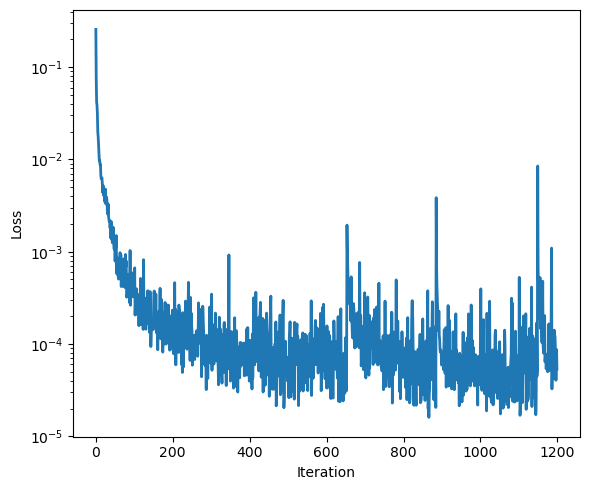

In [11]:
# 绘制损失曲线 - 与JAX代码风格一致
plt.figure(figsize=(6, 5))  # 与JAX代码相同的图像大小
plt.plot(loss_history, lw=2)  # 与JAX代码相同的线宽
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.tight_layout()
plt.show()

## 12. 模型测试和误差计算

生成测试数据，评估模型性能并计算相对L2误差。

In [12]:
# 生成测试数据 - 与JAX代码参数完全一致
print("生成测试数据...")
N_test = 100  # number of input samples - 与JAX代码一致
P_test = m    # number of sensors - 与JAX代码一致（P_test = m = 100）

# 计算多个测试样本的误差（与JAX代码逻辑一致）
errors = []
for i in range(N_test):
    u_test, y_test, s_test = generate_test_data(1, P_test, P_test, P_test, length_scale)
    
    # 模型预测
    model.eval()
    with torch.no_grad():
        u_test_tensor = torch.FloatTensor(u_test).to(device)
        y_test_tensor = torch.FloatTensor(y_test).to(device)
        
        s_pred = model(u_test_tensor, y_test_tensor).cpu().numpy()
    
    # 计算相对L2误差
    relative_error = np.linalg.norm(s_test.flatten() - s_pred.flatten()) / np.linalg.norm(s_test.flatten())
    errors.append(relative_error)

errors = np.array(errors)
print(f'Mean of relative L2 error of s: {errors.mean():.2e}')
print(f'Std of relative L2 error of s: {errors.std():.2e}')

生成测试数据...
Mean of relative L2 error of s: 1.59e-02
Std of relative L2 error of s: 8.30e-03


## 13. 结果可视化

可视化真实解、预测解以及它们之间的误差分布。

生成单个测试样本用于可视化...
Relative L2 error: 1.931e-02


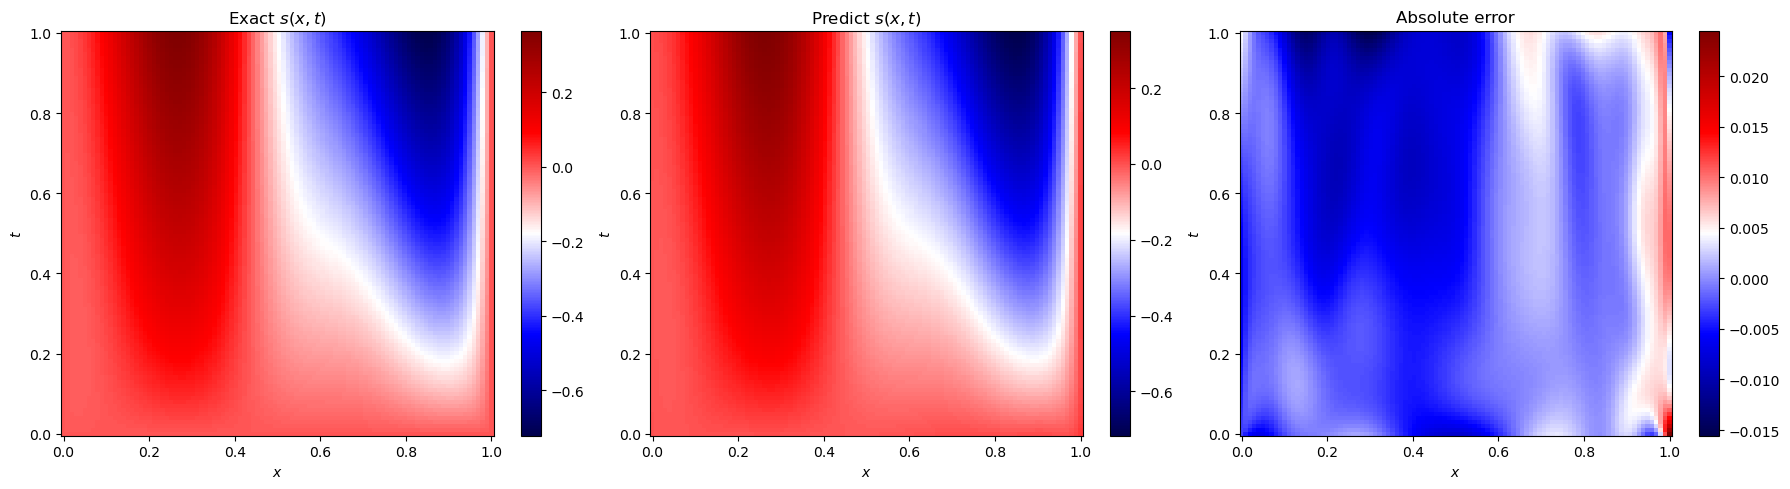

最终相对L2误差: 1.9308e-02


In [13]:
# 生成一个测试样本进行可视化 - 与JAX代码完全一致
print("生成单个测试样本用于可视化...")
P_test_vis = 100  # 与JAX代码一致
Nx_vis = m        # 与JAX代码一致

# 设置固定种子以确保结果可重复（模拟JAX的random.PRNGKey(12345)）
np.random.seed(12345)
u_test, y_test, s_test = generate_test_data(1, P_test_vis, P_test_vis, P_test_vis, length_scale)

# 模型预测
model.eval()
with torch.no_grad():
    u_test_tensor = torch.FloatTensor(u_test).to(device)
    y_test_tensor = torch.FloatTensor(y_test).to(device)
    
    s_pred = model(u_test_tensor, y_test_tensor).cpu().numpy()

# 生成均匀网格用于插值 - 与JAX代码一致
x = np.linspace(0, 1, Nx_vis)
t = np.linspace(0, 1, Nt)  # 使用原始的Nt=100
XX, TT = np.meshgrid(x, t)

# 网格数据插值 - 与JAX代码完全一致
S_pred = griddata(y_test, s_pred.flatten(), (XX, TT), method='cubic')
S_test = griddata(y_test, s_test.flatten(), (XX, TT), method='cubic')

# 计算相对L2误差
error = np.linalg.norm(S_pred - S_test, 2) / np.linalg.norm(S_test, 2)
print(f'Relative L2 error: {error:.3e}')

# 绘制结果 - 与JAX代码的绘图风格保持一致
fig = plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.pcolor(XX, TT, S_test, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $s(x,t)$')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.pcolor(XX, TT, S_pred, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predict $s(x,t)$')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(XX, TT, S_pred - S_test, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

print(f"最终相对L2误差: {error:.4e}")

## 14. 模型保存

保存训练好的模型以供后续使用。

In [14]:
# 保存模型 - 包含完整的训练信息
torch.save({
    'model_state_dict': model.state_dict(),
    'branch_layers': branch_layers,
    'trunk_layers': trunk_layers,
    'loss_history': loss_history,
    'training_iterations': nIter,
    'final_errors': errors if 'errors' in locals() else None
}, 'deeponet_diffusion_reaction_full.pth')

print("模型已保存为 'deeponet_diffusion_reaction_full.pth'")
print(f"训练参数总结:")
print(f"- 训练样本数: {N_samples}")
print(f"- 训练迭代次数: {nIter}")
print(f"- 批次大小: {batch_size}")
print(f"- Branch网络层数: {branch_layers}")
print(f"- Trunk网络层数: {trunk_layers}")
print(f"- 最终测试误差均值: {errors.mean():.2e}" if 'errors' in locals() else "")
print(f"- 最终测试误差标准差: {errors.std():.2e}" if 'errors' in locals() else "")

模型已保存为 'deeponet_diffusion_reaction_full.pth'
训练参数总结:
- 训练样本数: 5000
- 训练迭代次数: 120000
- 批次大小: 10000
- Branch网络层数: [100, 50, 50, 50, 50, 50]
- Trunk网络层数: [2, 50, 50, 50, 50, 50]
- 最终测试误差均值: 1.59e-02
- 最终测试误差标准差: 8.30e-03
